<a href="https://colab.research.google.com/github/DrDourado/Teaching_ME_615/blob/main/ME_615_07_Obj_Detection_and_Trasnfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook illustrates the basic concepts of object detection and transfer learning. In it the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) is used to demonstrate a object detection example through the concept of bounding boxes and the MobileNetV2 is tuned as a Feature Extractor.

In this notebook, will walk through the creation of a neural network capable of predicting both image classification and bounding box coordinates. Steps demonstrated in this notebook includes:

1. **Convolutional Neural Network (CNN) Architecture**: A simple CNN architecture is created using TensorFlow's Keras API. The architecture consists of convolutional layers followed by max-pooling layers and fully connected layers for image classification.
2. **Transfer Learning**: a machine learning technique where a pre-trained model—originally trained on a large dataset for a specific task—is adapted to a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge embedded in a well-trained model to improve efficiency and performance on a new problem.  
3. **Training the Model**: The model is trained using the Pascal VOC dataset. The loss function used for the classification task is sparse categorical crossentropy, and accuracy is used as the metric. For the regression problem related to obtaining the bounding boxes coordinates, mean-squared error is employed as the regression loss function.
4. **Visualizing Bounding Boxes After Training**: The trained models are used to make predictions on the validation set, and the predicted bounding boxes are visualized to assess the model's performance.

By going through this notebook, you should understand the basic workflow of building an object detection model.

**When to use Transfer Learning?**

This approach is particularly useful when:

* The new dataset is small and insufficient for training a deep neural network from scratch.
* The computational resources are limited, making full model training impractical.
* The new task shares similarities with the original task (e.g., both involve object detection or classification of natural images).

**How Does Transfer Learning Work?**

1. Choose a Pre-trained Model:
* A deep neural network (CNN) trained on a large dataset (e.g., ImageNet) is selected.
* Examples of popular pre-trained models include VGG16, ResNet, MobileNet, EfficientNet, and Inception.

2. Freeze the Convolutional Base:

* The pre-trained model contains layers that have already learned general features like edges, shapes, and textures.
* These layers are frozen (i.e., their weights are not updated) to retain learned feature representations.

3. Add a Custom Output Layer:

* Since the pre-trained model was built for a different classification task (e.g., classifying 1000 ImageNet objects), the final dense layers are removed and replaced with new layers tailored to the new task.
* For object detection, two new output layers are added:
  * Classification Output: Predicts the object class using a softmax layer.
  * Bounding Box Output: Predicts bounding box coordinates using a regression layer.

4. Fine-tuning (Optional): In some cases, after training the new layers, a few deeper layers of the pre-trained model are unfrozen and fine-tuned on the new dataset to adapt features better.

**Advantages of Transfer Learning**

* Faster Training: The model learns quickly since most of the feature extraction is already done.
* Better Performance with Less Data: Pre-trained models generalize well, requiring fewer training samples.
* Reduces Overfitting: Since the model is pre-trained on a large dataset, it generalizes better to new tasks.

**Transfer Learning in Object Detection**: In this notebook, we use MobileNetV2 as the feature extractor. MobileNetV2 is lightweight and optimized for real-time applications, making it ideal for object detection on limited hardware.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
def draw_bounding_boxes(image, boxes, labels):
    image = np.array(image * 255, dtype=np.uint8)
    for box, label in zip(boxes, labels):
        ymin, xmin, ymax, xmax = box
        start_point = (int(xmin * image.shape[1]), int(ymin * image.shape[0]))
        end_point = (int(xmax * image.shape[1]), int(ymax * image.shape[0]))
        image = cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)
        cv2.putText(image, label, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Create a CNN architecture for object detection
def create_model():
    image_input = Input(shape=(128, 128, 3))
    x1 = Conv2D(16, (3, 3), activation='relu')(image_input)
    x2 = MaxPooling2D((2, 2))(x1)
    x3 = Conv2D(16, (3, 3), activation='relu')(x2)
    x4 = MaxPooling2D((2, 2))(x3)
    x5 = Conv2D(16, (3, 3), activation='relu')(x4)
    x6 = MaxPooling2D((2, 2))(x5)
    x7 = Conv2D(16, (3, 3), activation='relu')(x6)
    x8 = MaxPooling2D((2, 2))(x7)
    x9 = Flatten()(x8)
    x10 = Dense(16, activation='relu')(x9)

    # Output layers for classification and bounding box regression
    class_output = Dense(20, activation='softmax', name='class')(x10)
    bbox_output = Dense(4, activation='sigmoid', name='bbox')(x10)

    model = Model(inputs=image_input, outputs=[class_output, bbox_output])
    return model

# Transfer Learning: Load pre-trained MobileNetV2 as a feature extractor
def load_pretrained_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False # Freeze convolutional layers

    image_input = Input(shape=(128, 128, 3))
    x = base_model(image_input, training=False)

    x1 = GlobalAveragePooling2D()(x)
    x2 = Flatten()(x1)
    x3 = Dense(32, activation='relu')(x2)

    # Output layers for classification and bounding box regression
    class_output = Dense(20, activation='softmax', name='class')(x3)
    bbox_output = Dense(4, activation='sigmoid', name='bbox')(x3)

    model = Model(inputs=image_input, outputs=[class_output, bbox_output])
    return model

# Prepare data for training
def prepare_data(dataset):
    images = []
    bboxes = []
    classes = []
    for example in dataset:
        # Check if 'objects' key exists and contains necessary data
        if 'objects' in example and 'bbox' in example['objects'] and 'label' in example['objects']:
            image = example['image']
            image = tf.image.resize(image, (128, 128))  # Resize image to match model input

            # Get bounding boxes and labels
            num_bboxes = example['objects']['bbox'].shape[0] if example['objects']['bbox'].shape else 0
            num_classes = example['objects']['label'].shape[0] if example['objects']['label'].shape else 0

            # If there are no bounding boxes or classes, skip this example
            if num_bboxes == 0 or num_classes == 0:
                continue

            # Handle multiple objects in an image by repeating the image
            for i in range(min(num_bboxes, num_classes)):  # Iterate through objects
                images.append(image.numpy())
                bboxes.append(example['objects']['bbox'].numpy()[i])  # Get single bounding box
                classes.append(example['objects']['label'].numpy()[i])  # Get single class label

    return np.array(images), np.array(bboxes), np.array(classes)

# Calculate IoU metric
def iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return interArea / float(box1Area + box2Area - interArea)

In [3]:
# Load Pascal VOC dataset
(ds_train, ds_test), ds_info = tfds.load("voc/2007", split=["train", "test"], with_info=True)

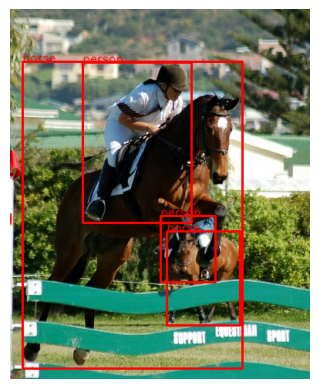

In [4]:
for example in ds_train.take(1):
    image = example['image'].numpy() / 255.0
    boxes = example['objects']['bbox'].numpy()
    labels = example['objects']['label'].numpy()
    labels = [ds_info.features['objects']['label'].int2str(int(l)) for l in labels]
    draw_bounding_boxes(image, boxes, labels)
    break

In [5]:
# Prepare training and validation data
train_images, train_bboxes, train_classes = prepare_data(ds_train)
test_images, test_bboxes, test_classes = prepare_data(ds_test)

In [6]:
# Define a simple CNN model for object detection and classification
cnn_model = create_model()
cnn_model.compile(optimizer='adam',
              loss={'bbox': 'mse', 'class': 'sparse_categorical_crossentropy'},
              metrics={'bbox': 'mse', 'class': 'accuracy'})

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 16)     │          2,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 16)     │          2,320 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 16)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 12, 12, 16)     │          2,320 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 6, 16)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 576)            │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │          9,232 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 20)             │            340 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox (Dense)              │ (None, 4)              │             68 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,048 (66.59 KB)

 Trainable params: 17,048 (66.59 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define a CNN model based on the pre-trained model
transfer_cnn_model = load_pretrained_model()
transfer_cnn_model.compile(optimizer='adam',
                           loss={'bbox': 'mse', 'class': 'sparse_categorical_crossentropy'},
                           metrics={'bbox': 'mse', 'class': 'accuracy'})

In [8]:
transfer_cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_128      │ (None, 4, 4, 1280)     │      2,257,984 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_128[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │         40,992 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 20)             │            660 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox (Dense)              │ (None, 4)              │            132 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,299,768 (8.77 MB)

 Trainable params: 41,784 (163.22 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
IoU: 0.0
Predicted Class: bicycle | True Class: dog


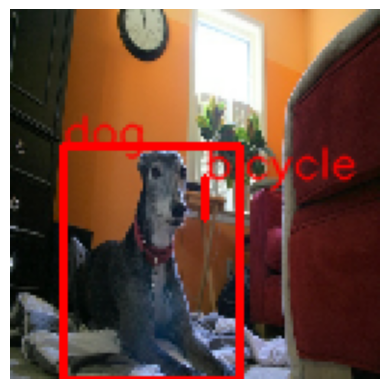

In [9]:
# Example evaluation: No Transfer Learning
for example in ds_test.take(1):
    image = tf.image.resize(example['image'], (128, 128)) / 255.0
    true_box = example['objects']['bbox'].numpy()[0]
    true_label = example['objects']['label'].numpy()[0]
    true_label = ds_info.features['objects']['label'].int2str(int(true_label))

    pred = cnn_model.predict(tf.expand_dims(image, axis=0))
    pred_box = pred[1]
    pred_class = np.argmax(pred[0])
    pred_label = ds_info.features['objects']['label'].int2str(int(pred_class))

    print("IoU:", iou(pred_box[0], true_box))
    print("Predicted Class:", pred_label, "| True Class:", true_label)
    draw_bounding_boxes(image.numpy(), [pred_box[0], true_box], [pred_label, true_label])
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
IoU: 0.004200575434552702
Predicted Class: aeroplane | True Class: dog


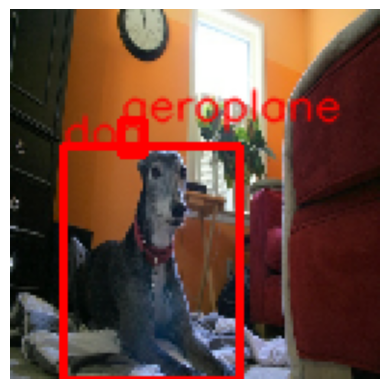

In [10]:
# Example evaluation: With Transfer Learning
for example in ds_test.take(1):
    image = tf.image.resize(example['image'], (128, 128)) / 255.0
    true_box = example['objects']['bbox'].numpy()[0]
    true_label = example['objects']['label'].numpy()[0]
    true_label = ds_info.features['objects']['label'].int2str(int(true_label))

    transfer_pred = transfer_cnn_model.predict(tf.expand_dims(image, axis=0))
    transfer_pred_box = transfer_pred[1]
    transfer_pred_class = np.argmax(transfer_pred[0])
    transfer_pred_label = ds_info.features['objects']['label'].int2str(int(transfer_pred_class))

    print("IoU:", iou(transfer_pred_box[0], true_box))
    print("Predicted Class:", transfer_pred_label, "| True Class:", true_label)
    draw_bounding_boxes(image.numpy(), [transfer_pred_box[0], true_box], [transfer_pred_label, true_label])
    break

**Given the amount and size of employed data we can crash the training session due to lack of RAM resources!**

In [11]:
# Callback functions to track training
run_file = 00
checkpoint_path = "transfer_cnn_model_run_"+str(run_file)+"/cp.ckpt.checkpoint.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_bbox_loss', save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_bbox_loss', mode='min', patience=5, restore_best_weights=True)

In [ ]:
# Train the CNN model
history = transfer_cnn_model.fit(train_images,  # Pass image data
                                 {'class': train_classes, 'bbox': train_bboxes},  # Pass labels and bounding boxes as a dictionary
                                 validation_data=(test_images, {'class': test_classes, 'bbox': test_bboxes}),
                                 epochs=10, batch_size = 128, callbacks=[early_stopping, checkpoint])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - bbox_loss: 0.0891 - bbox_mse: 0.0891 - class_accuracy: 0.3272 - class_loss: 2.5358 - loss: 2.6249

In [ ]:
# Load best model and evaluate
# transfer_cnn_model.load_weights(checkpoint_path)

In [ ]:
# Example evaluation
for example in ds_test.take(1):
    image = tf.image.resize(example['image'], (128, 128)) / 255.0
    true_box = example['objects']['bbox'].numpy()[0]
    true_label = example['objects']['label'].numpy()[0]
    true_label = ds_info.features['objects']['label'].int2str(int(true_label))

    trained_pred = transfer_cnn_model.predict(tf.expand_dims(image, axis=0))
    trained_pred_box = trained_pred[1]
    trained_pred_class = np.argmax(trained_pred[0])
    trained_pred_label = ds_info.features['objects']['label'].int2str(int(trained_pred_class))

    print("IoU:", iou(trained_pred_box[0], true_box))
    print("Predicted Class:", trained_pred_label, "| True Class:", true_label)
    draw_bounding_boxes(image.numpy(), [trained_pred_box[0], true_box], [trained_pred_label, true_label])
    break